In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
import seaborn as sns
import matplotlib as plt
%matplotlib inline

In [3]:
def get_go_terms():
    f_name = '../data/GO_terms_final_gene_counts.txt'
    GO_counts_file = open(f_name)

    terms = []
    for (i, line) in enumerate(GO_counts_file):
        if i < 2:
            continue
        term = line.split('\t')[0]
        terms.append(term)
    return terms

def get_tissue_list(tissue_fpath):
    tissue_file = open(tissue_fpath)
    for line in tissue_file:
        tissues = line.rstrip().split('\t')
        break
    return tissues

def get_1_tissue_aucs(GO_term, tissue_list):
    """
    This function gets the AUC scores of predicting the gene associations of 
    |GO_term| where each prediction task only used features from an individual
    tissue.
    
    :param GO_term: The GO term
    :param tissue_list: List of tissues that were used for separate prediction
    tasks. If len(tissue_list)=53, then we performed 53 separate prediciton
    problems, where each prediction problem used a different 1 of the 53 tissues.
    :return: A list of AUC scores in the same order as |tissue_list|. The ith element in this
    list is the AUC score for predicting this GO term using only tissue i.
    """
    
    aucs_1_tissue = []
    results_dir = '../GO_prediction/Results/full_results_1_tissue_loss_l2_neg_0/' + GO_term + '_neg_0/'
    for tissue in tissue_list:
        # Get the AUC score when using features from only this tissue
        f_name = results_dir + 'logreg_' + tissue + '.txt'
        rf = open(f_name)
        for (i, line) in enumerate(rf):
            if i == 2:
                auc_score = float(line.split(' ')[-1])
                aucs_1_tissue.append(auc_score)
            elif i > 2:
                break
    return aucs_1_tissue

def get_all_1_tissue_aucs(GO_terms, tissue_list):
    aucs = np.zeros(shape=(len(GO_terms),len(tissue_list)))  # aucs[i][j] is auc score for using jth tissue features to predict ith GO term
    for (i, term) in enumerate(GO_terms):
        aucs[i, :] = get_1_tissue_aucs(term, tissue_list)
    return aucs

#def get_all_feature_aucs():

In [4]:
def map_GO_to_GTEX():
    inputFilename = '../data/GO_terms_final_gene_counts.txt'
    GO_list_file = open(inputFilename)
    GO_list = np.loadtxt(GO_list_file,skiprows=2,usecols=[0],dtype='S10',delimiter='\t')
    
    inputFilename = '../data/Tissue_Name_Mappings.csv'
    tissue_data = pd.read_csv(inputFilename,header=None)
    map_BTO_to_GTEX = defaultdict(list)

    for index,row in tissue_data.iterrows():
        GTEX_tissue = row[0]
        BTO_tissues = row[1:]
        for tissue in BTO_tissues.dropna():
            map_BTO_to_GTEX[tissue].append(GTEX_tissue)

    inputFilename = '../data/BTO_GO.csv'
    BTO_data = pd.read_csv(inputFilename,skiprows=[0])
    map_GO_to_GTEX = defaultdict(list)

    for index,row in BTO_data.iterrows():
        tissue = row[1]
        if tissue in map_BTO_to_GTEX:
            GO_IDs = row[2:]
            for GO_ID in GO_IDs.dropna():
                if GO_ID in GO_list:
                    map_GO_to_GTEX[GO_ID] = list(set(map_GO_to_GTEX[GO_ID] + map_BTO_to_GTEX[tissue]))

    #inputFile.close()
    return map_GO_to_GTEX

def map_GTEX_to_GO(map_GO_to_GTEX):
    GTEX_to_GO = defaultdict(list)
    for GO_ID,tissues in map_GO_to_GTEX.items():
        for tissue in tissues:
            if GO_ID not in GTEX_to_GO[tissue]:
                GTEX_to_GO[tissue].append(GO_ID)
    return GTEX_to_GO
   
def map_GTEX_to_cols(dir_path, tissues):
    GTEX_to_samples = {}
    for tissue in tissues:
        cols = []
        fpath = dir_path + 'tissue_meta_' + tissue + '.txt'
        meta_file = open(fpath)
        for (i, line) in enumerate(meta_file):
            if i < 1:
                continue
            else:
                cols.append(int(line.split('\t')[0]))
        GTEX_to_samples[tissue] = cols
        meta_file.close()
    return GTEX_to_samples

In [5]:
GO_terms = get_go_terms()
all_tissues = get_tissue_list('../data/tissues.txt')
aucs = get_all_1_tissue_aucs(GO_terms, all_tissues)

## Median AUC Maps

In [6]:
GO_to_GTEX = map_GO_to_GTEX()
GO_terms_tissues = [GO_to_GTEX[GO_ID] for GO_ID in GO_terms]

median_auc_by_tissue = pd.DataFrame(0.0,index=all_tissues,columns=all_tissues)

for j, tissue in enumerate(all_tissues):
    for GO_tissue in all_tissues:
        # array of aucs for all GO terms mapped to 'GO_tissue' as predicted by 'tissue'
        tissue_aucs = [aucs[i,j] for i in range(len(GO_terms)) if GO_tissue in GO_terms_tissues[i]]
        # if there are any GO terms mapped to this tissue
        if tissue_aucs:
            # find the median AUC and put it in the appropriate spot in the dataframe
            median_auc = np.median(tissue_aucs)
            median_auc_by_tissue[tissue][GO_tissue] = median_auc

### Clustermap (empty rows dropped)

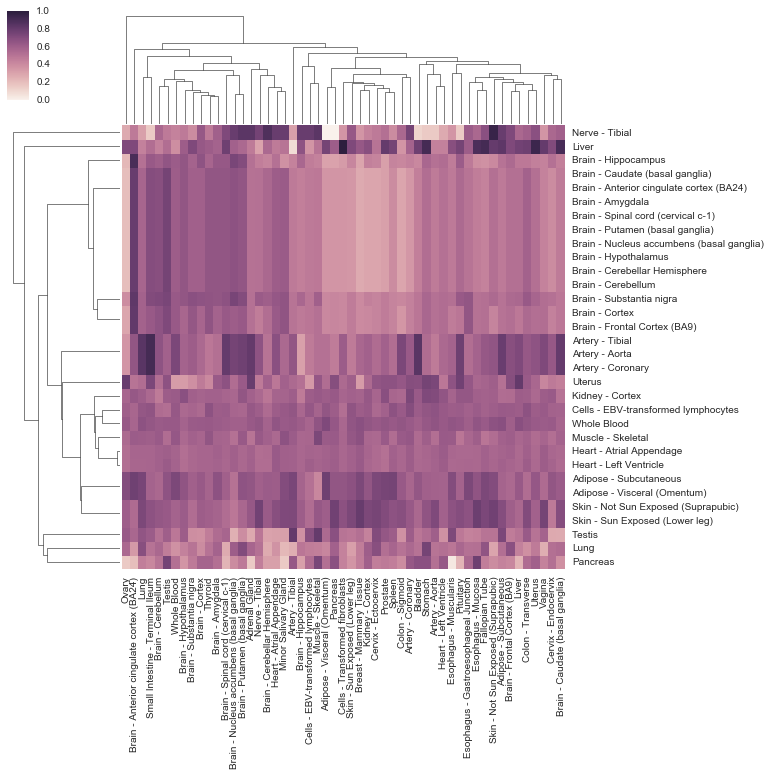

In [7]:
# drop empty rows
for GO_tissue in median_auc_by_tissue.index:
    row = median_auc_by_tissue.ix[GO_tissue]
    if all(auc==0 for auc in row):
        median_auc_by_tissue = median_auc_by_tissue.drop([GO_tissue],axis=0)

fig = plt.pyplot.figure(figsize=(13,10))
cluster = sns.clustermap(median_auc_by_tissue)
sns.plt.setp(cluster.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
sns.plt.show()

### Clustermap (empty rows dropped, identical rows collapsed)

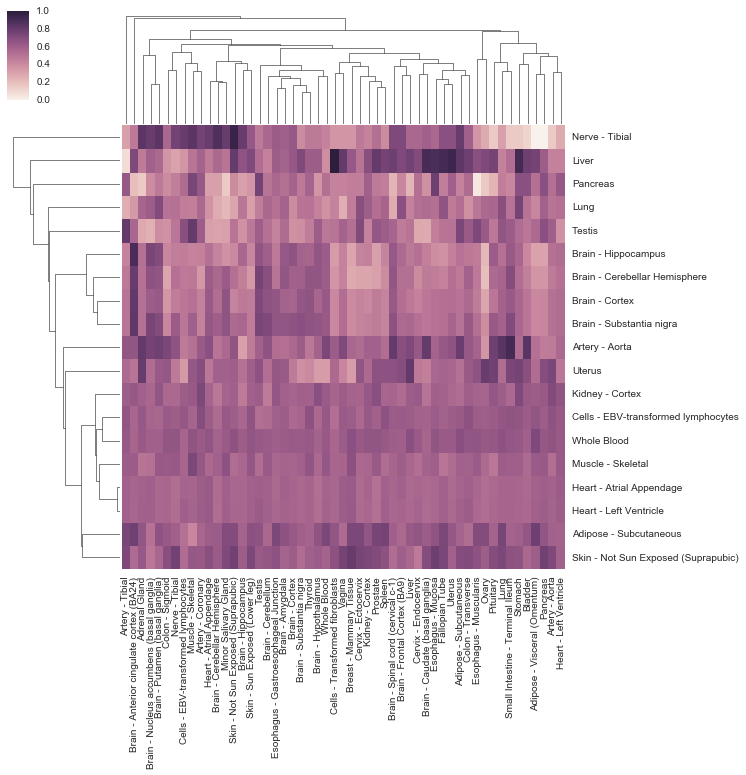

In [8]:
# collapse identical rows
median_auc_by_tissue = median_auc_by_tissue.drop_duplicates()
fig = plt.pyplot.figure(figsize=(13,10))
cluster = sns.clustermap(median_auc_by_tissue)
sns.plt.setp(cluster.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
sns.plt.show()

### Heatmap - top 3 per col (empty rows dropped, identical rows collapsed)
#### Rows near the top of the heatmap are tissues that are very predictable: The median of the AUC scores for functions of that tissue are often in the top 3 best AUC scores as predicted by column's tissue

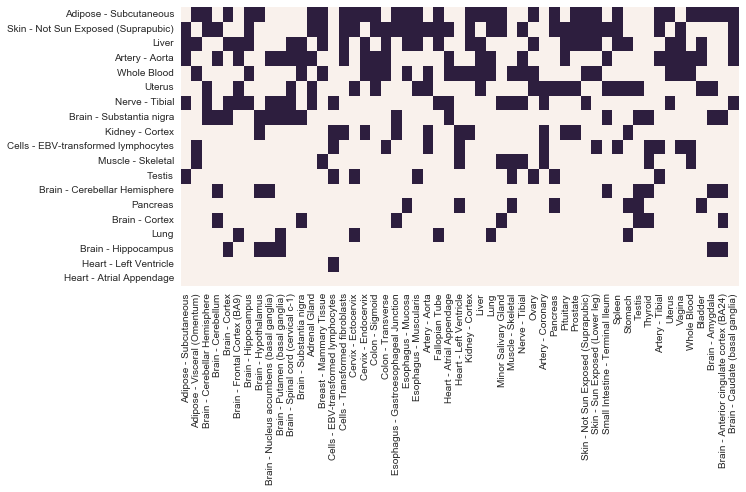

In [9]:
median_auc_top_per_col = pd.DataFrame(0,index = median_auc_by_tissue.index.values,columns=median_auc_by_tissue.columns.values)

for col in median_auc_by_tissue:
    column_rank = median_auc_by_tissue[col].rank(ascending=False,method='first')
    for i in range(len(column_rank)):
        if column_rank[i] <= 5:
            median_auc_top_per_col[col][i] = 1

row_tissues = median_auc_top_per_col.index.values
row_sums = np.zeros(len(row_tissues))


for i,tissue in enumerate(row_tissues):
    row_sums[i] = sum(median_auc_top_per_col.ix[tissue])


new_order = [x for (y,x) in sorted(zip(row_sums,row_tissues),reverse=True)]
median_auc_top_per_col = median_auc_top_per_col.reindex(index=new_order)

fig = plt.pyplot.figure(figsize=(10,5))
#sns.plt.setp(cluster.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
sns.heatmap(median_auc_top_per_col,cbar=False)
sns.plt.show()

### Heatmap - top 3 per row (empty rows dropped, identical rows collapsed)
#### Columns near the left of the heatmap are tissues that are very predictive: The median of the AUC scores as predicted by that tissue are often in the top 3 best AUC scores for functions of the row's tissue

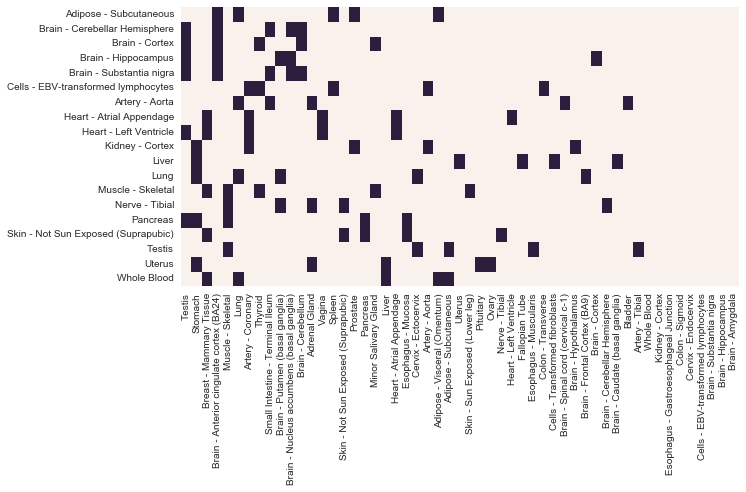

In [10]:
median_auc_top_per_row = pd.DataFrame(0,index = median_auc_by_tissue.index.values,columns=median_auc_by_tissue.columns.values)


for row in median_auc_by_tissue.index:
    row_rank = median_auc_by_tissue.ix[row].rank(ascending=False,method='first')
    
    for i in range(len(row_rank)):
        if row_rank[i] <= 5:
            median_auc_top_per_row.ix[row][i] = 1

col_tissues = median_auc_top_per_row.columns.values
col_sums = np.zeros(len(col_tissues))

for i,tissue in enumerate(col_tissues):
    col_sums[i] = sum(median_auc_top_per_row[tissue])

new_order = [x for (y,x) in sorted(zip(col_sums,col_tissues),reverse=True)]
median_auc_top_per_row = median_auc_top_per_row.reindex(columns=new_order)

fig = plt.pyplot.figure(figsize=(10,5))
sns.heatmap(median_auc_top_per_row,cbar=False)
sns.plt.show()

## Mean AUC Maps - Same plots as above, but using mean AUC

In [11]:
GO_to_GTEX = map_GO_to_GTEX()
GO_terms_tissues = [GO_to_GTEX[GO_ID] for GO_ID in GO_terms]

mean_auc_by_tissue = pd.DataFrame(0.0,index=all_tissues,columns=all_tissues)

for j, tissue in enumerate(all_tissues):
    for GO_tissue in all_tissues:
        # array of aucs for all GO terms mapped to 'GO_tissue' as predicted by 'tissue'
        tissue_aucs = [aucs[i,j] for i in range(len(GO_terms)) if GO_tissue in GO_terms_tissues[i]]
        # if there are any GO terms mapped to this tissue
        if tissue_aucs:
            # find the median AUC and put it in the appropriate spot in the dataframe
            mean_auc = np.mean(tissue_aucs)
            mean_auc_by_tissue[tissue][GO_tissue] = mean_auc

### Clustermap (empty rows dropped)

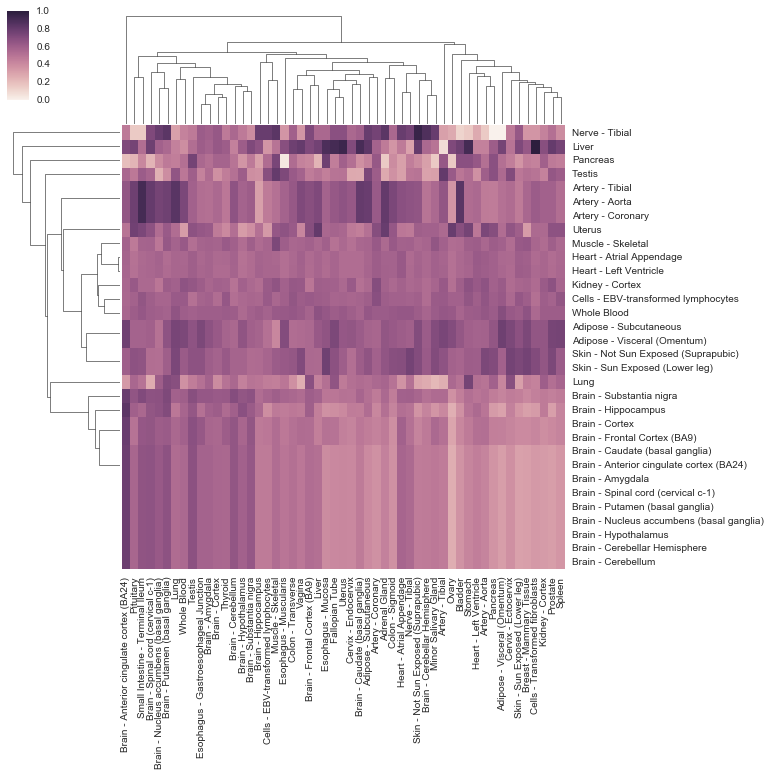

In [12]:
# drop empty rows
for GO_tissue in mean_auc_by_tissue.index:
    row = mean_auc_by_tissue.ix[GO_tissue]
    if all(auc==0 for auc in row):
        mean_auc_by_tissue = mean_auc_by_tissue.drop([GO_tissue],axis=0)

fig = plt.pyplot.figure(figsize=(13,10))
cluster = sns.clustermap(mean_auc_by_tissue)
sns.plt.setp(cluster.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
sns.plt.show()

### Clustermap (empty rows dropped, identical rows collapsed)

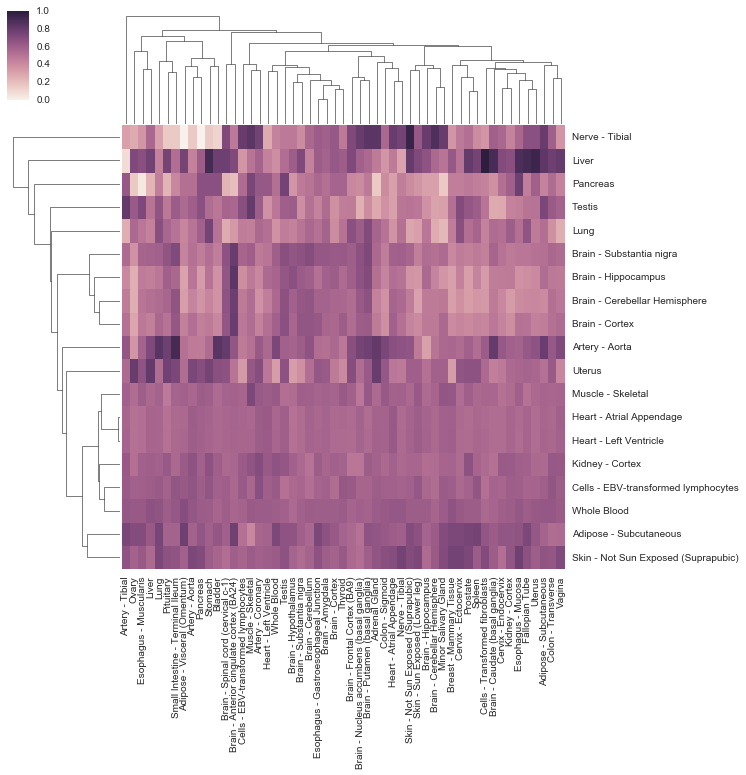

In [13]:
# collapse identical rows
mean_auc_by_tissue = mean_auc_by_tissue.drop_duplicates()
fig = plt.pyplot.figure(figsize=(13,10))
cluster = sns.clustermap(mean_auc_by_tissue)
sns.plt.setp(cluster.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
sns.plt.show()

### Heatmap - top 3 per col (empty rows dropped, identical rows collapsed)
#### Rows near the top of the heatmap are tissues that are very predictable: The mean of the AUC scores for functions of that tissue are often in the top 3 best AUC scores as predicted by column's tissue

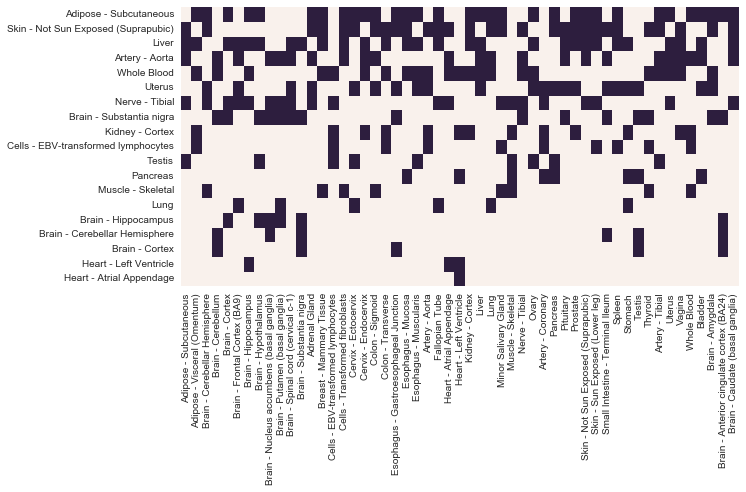

In [14]:
mean_auc_top_per_col = pd.DataFrame(0,index = mean_auc_by_tissue.index.values,columns=mean_auc_by_tissue.columns.values)

for col in mean_auc_by_tissue:
    column_rank = mean_auc_by_tissue[col].rank(ascending=False,method='first')
    for i in range(len(column_rank)):
        if column_rank[i] <= 5:
            mean_auc_top_per_col[col][i] = 1

row_tissues = mean_auc_top_per_col.index.values
row_sums = np.zeros(len(row_tissues))


for i,tissue in enumerate(row_tissues):
    row_sums[i] = sum(mean_auc_top_per_col.ix[tissue])


new_order = [x for (y,x) in sorted(zip(row_sums,row_tissues),reverse=True)]
mean_auc_top_per_col = mean_auc_top_per_col.reindex(index=new_order)

fig = plt.pyplot.figure(figsize=(10,5))
#sns.plt.setp(cluster.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
sns.heatmap(mean_auc_top_per_col,cbar=False)
sns.plt.show()

### Heatmap - top 3 per row (empty rows dropped, identical rows collapsed)
#### Columns near the left of the heatmap are tissues that are very predictive: The mean of the AUC scores as predicted by that tissue are often in the top 3 best AUC scores for functions of the row's tissue

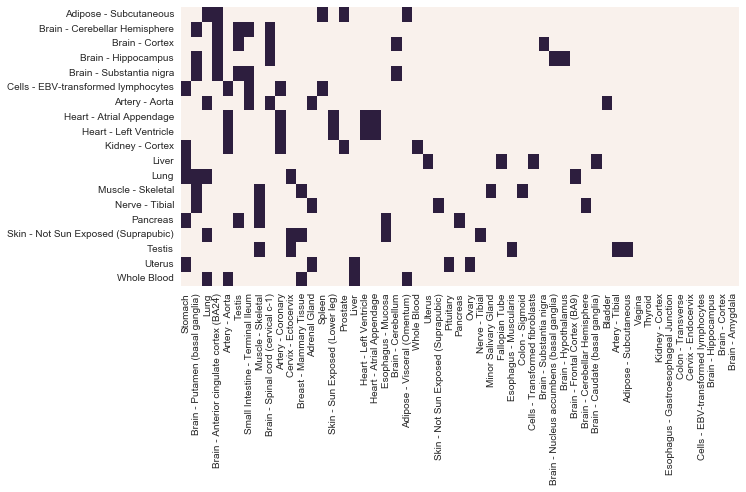

In [15]:
mean_auc_top_per_row = pd.DataFrame(0,index = mean_auc_by_tissue.index.values,columns=mean_auc_by_tissue.columns.values)


for row in mean_auc_by_tissue.index:
    row_rank = mean_auc_by_tissue.ix[row].rank(ascending=False,method='first')
    
    for i in range(len(row_rank)):
        if row_rank[i] <= 5:
            mean_auc_top_per_row.ix[row][i] = 1

col_tissues = mean_auc_top_per_row.columns.values
col_sums = np.zeros(len(col_tissues))

for i,tissue in enumerate(col_tissues):
    col_sums[i] = sum(mean_auc_top_per_row[tissue])

new_order = [x for (y,x) in sorted(zip(col_sums,col_tissues),reverse=True)]
mean_auc_top_per_row = mean_auc_top_per_row.reindex(columns=new_order)

fig = plt.pyplot.figure(figsize=(10,5))
sns.heatmap(mean_auc_top_per_row,cbar=False)
sns.plt.show()

## Max AUC Maps - Same plots as above, but using max AUC

In [29]:
GO_to_GTEX = map_GO_to_GTEX()
GO_terms_tissues = [GO_to_GTEX[GO_ID] for GO_ID in GO_terms]

max_auc_by_tissue = pd.DataFrame(0.0,index=all_tissues,columns=all_tissues)

for j, tissue in enumerate(all_tissues):
    for GO_tissue in all_tissues:
        # array of aucs for all GO terms mapped to 'GO_tissue' as predicted by 'tissue'
        tissue_aucs = [aucs[i,j] for i in range(len(GO_terms)) if GO_tissue in GO_terms_tissues[i]]
        # if there are any GO terms mapped to this tissue
        if tissue_aucs:
            # find the median AUC and put it in the appropriate spot in the dataframe
            max_auc = np.max(tissue_aucs)
            max_auc_by_tissue[tissue][GO_tissue] = max_auc

### Clustermap (empty rows dropped)

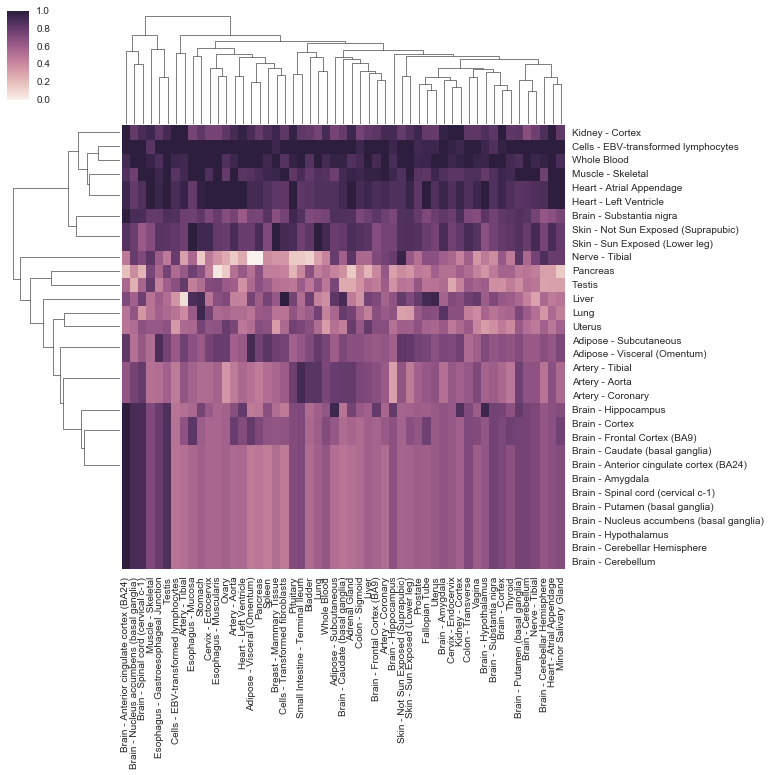

In [30]:
# drop empty rows
for GO_tissue in max_auc_by_tissue.index:
    row = max_auc_by_tissue.ix[GO_tissue]
    if all(auc==0 for auc in row):
        max_auc_by_tissue = max_auc_by_tissue.drop([GO_tissue],axis=0)

fig = plt.pyplot.figure(figsize=(13,10))
cluster = sns.clustermap(max_auc_by_tissue)
sns.plt.setp(cluster.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
sns.plt.show()

### Clustermap (empty rows dropped, identical rows collapsed)

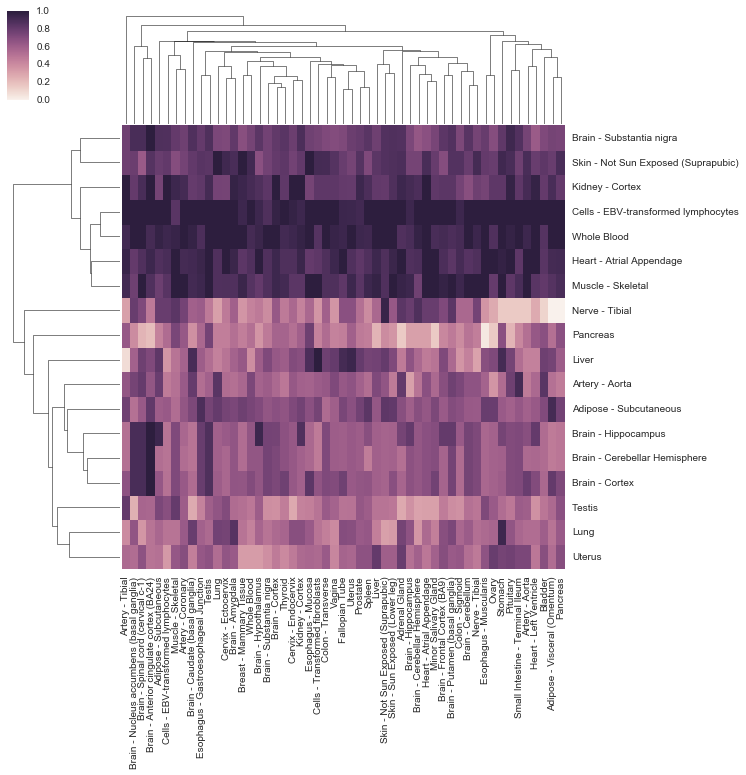

In [31]:
# collapse identical rows
max_auc_by_tissue = max_auc_by_tissue.drop_duplicates()
fig = plt.pyplot.figure(figsize=(13,10))
cluster = sns.clustermap(max_auc_by_tissue)
sns.plt.setp(cluster.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
sns.plt.show()

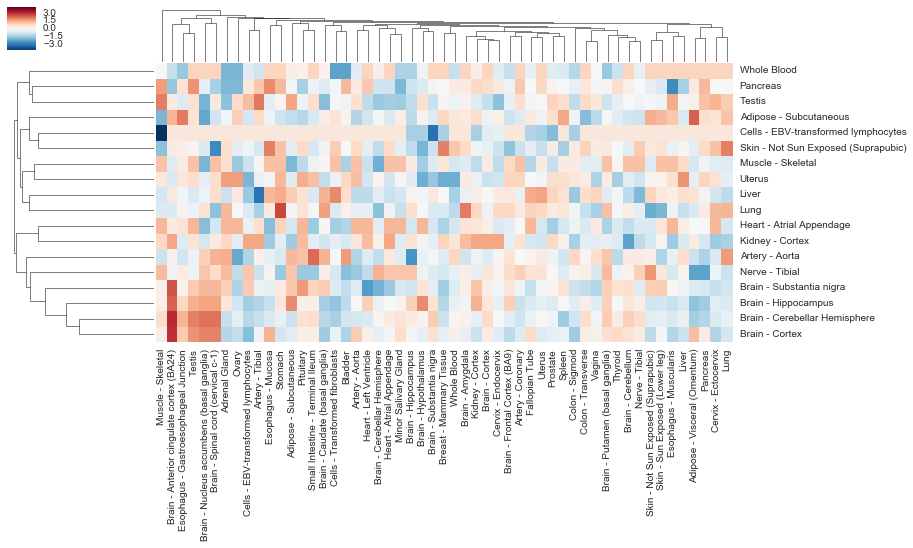

In [38]:
# ROW ADJUSTED
max_auc_row_adjusted = pd.DataFrame(0,index = max_auc_by_tissue.index.values,columns=max_auc_by_tissue.columns.values)

for row in max_auc_by_tissue.index:
    row_mean = np.mean(max_auc_by_tissue.ix[row])
    row_std = np.std(max_auc_by_tissue.ix[row])
    max_auc_row_adjusted.ix[row] = (max_auc_by_tissue.ix[row] - row_mean)/row_std
    #row_max = max(max_auc_by_tissue.ix[row])
    #max_auc_row_adjusted.ix[row] = max_auc_by_tissue.ix[row]/row_max
    
fig = plt.pyplot.figure()
cluster = sns.clustermap(max_auc_row_adjusted,figsize=(13,6))
sns.plt.setp(cluster.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
sns.plt.show()

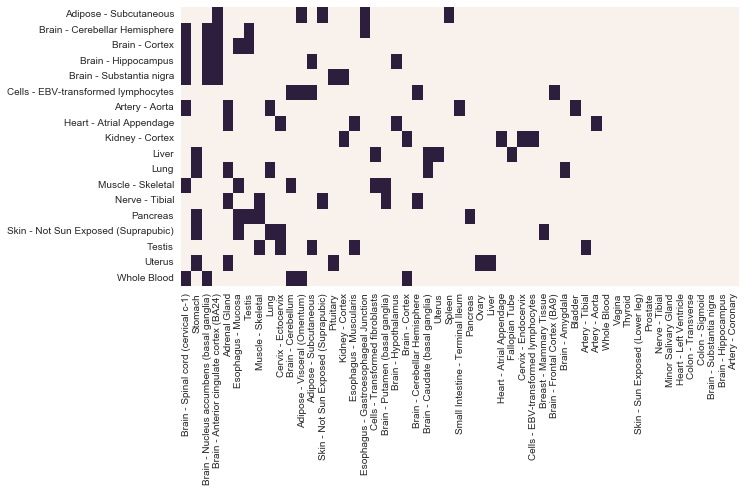

ValueError: Linkage 'Z' contains negative indices.

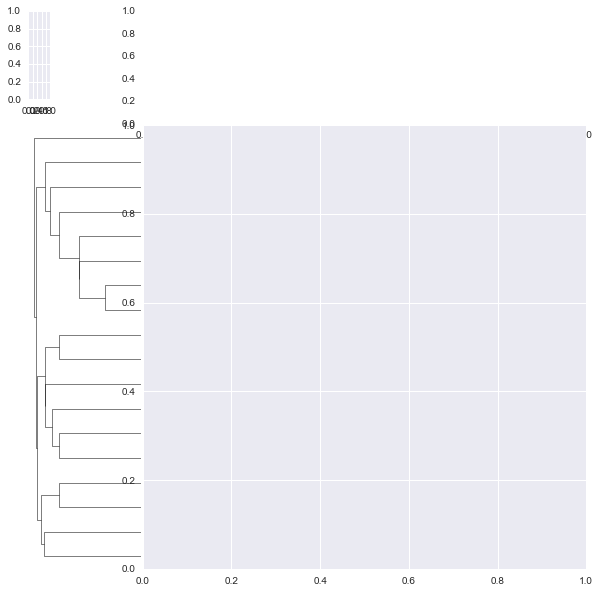

In [39]:
max_auc_top_per_row_adjusted = pd.DataFrame(0,index = max_auc_row_adjusted.index.values,columns=max_auc_row_adjusted.columns.values)


for row in max_auc_row_adjusted.index:
    row_rank = max_auc_row_adjusted.ix[row].rank(ascending=False,method='first')
    
    for i in range(len(row_rank)):
        if row_rank[i] <= 5:
            max_auc_top_per_row_adjusted.ix[row][i] = 1

col_tissues = max_auc_top_per_row_adjusted.columns.values
col_sums = np.zeros(len(col_tissues))

for i,tissue in enumerate(col_tissues):
    col_sums[i] = sum(max_auc_top_per_row_adjusted[tissue])

new_order = [x for (y,x) in sorted(zip(col_sums,col_tissues),reverse=True)]
max_auc_top_per_row_adjusted = max_auc_top_per_row_adjusted.reindex(columns=new_order)

fig = plt.pyplot.figure(figsize=(10,5))
sns.heatmap(max_auc_top_per_row_adjusted,cbar=False)
sns.plt.show()

fig = plt.pyplot.figure(figsize=(13,10))
cluster = sns.clustermap(max_auc_top_per_row_adjusted,metric='jaccard')
sns.plt.setp(cluster.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
sns.plt.show()

### Heatmap - top 3 per col (empty rows dropped, identical rows collapsed)
#### Rows near the top of the heatmap are tissues that are very predictable: The max of the AUC scores for functions of that tissue are often in the top 3 best AUC scores as predicted by column's tissue

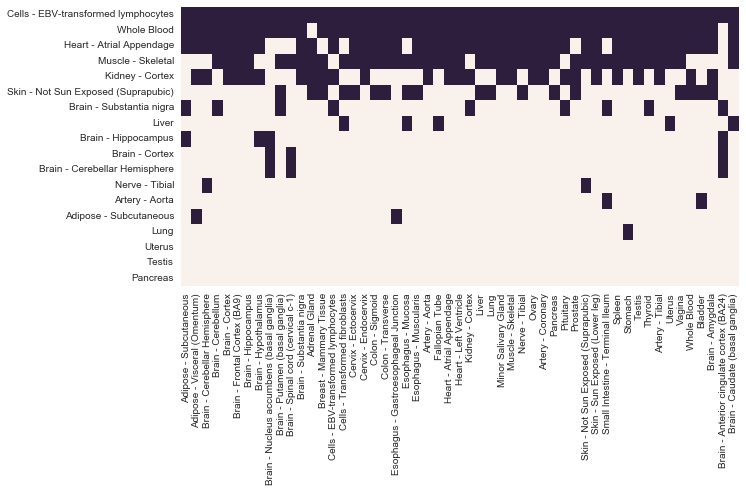

In [23]:
max_auc_top_per_col = pd.DataFrame(0,index = max_auc_by_tissue.index.values,columns=max_auc_by_tissue.columns.values)

for col in max_auc_by_tissue:
    column_rank = max_auc_by_tissue[col].rank(ascending=False,method='first')
    for i in range(len(column_rank)):
        if column_rank[i] <= 5:
            max_auc_top_per_col[col][i] = 1

row_tissues = max_auc_top_per_col.index.values
row_sums = np.zeros(len(row_tissues))


for i,tissue in enumerate(row_tissues):
    row_sums[i] = sum(max_auc_top_per_col.ix[tissue])


new_order = [x for (y,x) in sorted(zip(row_sums,row_tissues),reverse=True)]
max_auc_top_per_col = max_auc_top_per_col.reindex(index=new_order)

fig = plt.pyplot.figure(figsize=(10,5))
#sns.plt.setp(cluster.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
sns.heatmap(max_auc_top_per_col,cbar=False)
sns.plt.show()



### Heatmap - top 3 per row (empty rows dropped, identical rows collapsed)
#### Columns near the left of the heatmap are tissues that are very predictive: The max of the AUC scores as predicted by that tissue are often in the top 3 best AUC scores for functions of the row's tissue

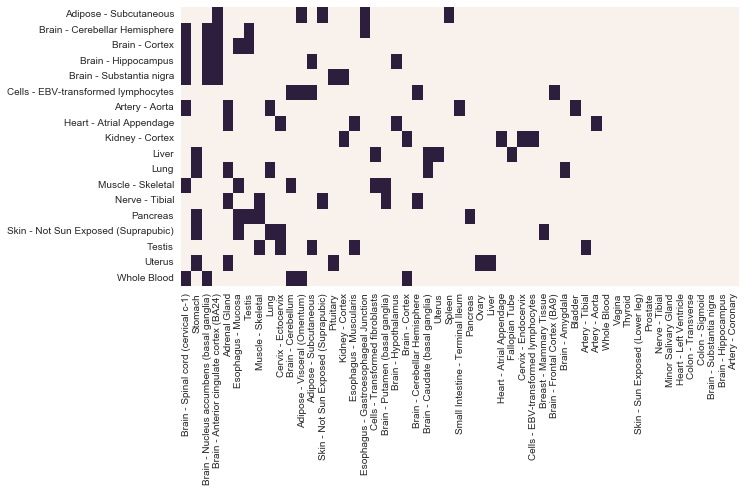

ValueError: Linkage 'Z' contains negative indices.

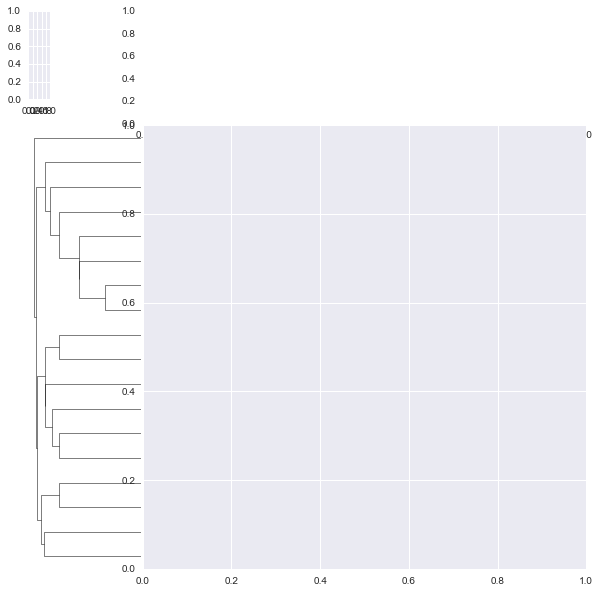

In [30]:
max_auc_top_per_row = pd.DataFrame(0,index = max_auc_by_tissue.index.values,columns=max_auc_by_tissue.columns.values)


for row in max_auc_by_tissue.index:
    row_rank = max_auc_by_tissue.ix[row].rank(ascending=False,method='first')
    
    for i in range(len(row_rank)):
        if row_rank[i] <= 5:
            max_auc_top_per_row.ix[row][i] = 1

col_tissues = max_auc_top_per_row.columns.values
col_sums = np.zeros(len(col_tissues))

for i,tissue in enumerate(col_tissues):
    col_sums[i] = sum(max_auc_top_per_row[tissue])

new_order = [x for (y,x) in sorted(zip(col_sums,col_tissues),reverse=True)]
max_auc_top_per_row = max_auc_top_per_row.reindex(columns=new_order)

fig = plt.pyplot.figure(figsize=(10,5))
sns.heatmap(max_auc_top_per_row,cbar=False)
sns.plt.show()

fig = plt.pyplot.figure(figsize=(13,10))
cluster = sns.clustermap(max_auc_top_per_row,metric='jaccard')
sns.plt.setp(cluster.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
sns.plt.show()